# 課題２
* 今回は、以下のモデルについて、事後分布からサンプルを得た。
$$ \mu \sim N(0, 1) $$
$$ x \sim N(\mu, 1) $$
* しかし、事前分布が共役であるため、このモデルについては手計算でも事後分布を計算できる。
* そこで、$\mu$が従う事後分布の密度関数を計算し、`arviz.plot_trace()`による可視化がその関数に近い形になっていたか、確認してみよう。

In [1]:
!pip install arviz
!pip install numpyro

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.2/300.2 kB 5.0 MB/s eta 0:00:00


In [41]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import jax
import jax.numpy as jnp
from jax import random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import NUTS, MCMC, Predictive

import arviz as az

%config InlineBackend.figure_format = 'retina'

rng_key = random.PRNGKey(0)
az.style.use("arviz-darkgrid")
numpyro.set_platform("cpu")

# モデル

In [45]:
rng_key, rng_key_ = random.split(rng_key)
observed = jax.random.normal(rng_key_, (100,))

def model(data=None):
  mu = numpyro.sample("mu", dist.Normal(0, 1))
  obs = numpyro.sample("obs", dist.Normal(mu, 1), obs=data)

In [46]:
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=2)
rng_key, rng_key_ = random.split(rng_key)
mcmc.run(rng_key_, data=observed)

<ipython-input-46-7c585fd3c566>:2: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=2)
sample: 100%|██████████| 2000/2000 [00:00<00:00, 2681.37it/s, 3 steps of size 8.94e-01. acc. prob=0.94]


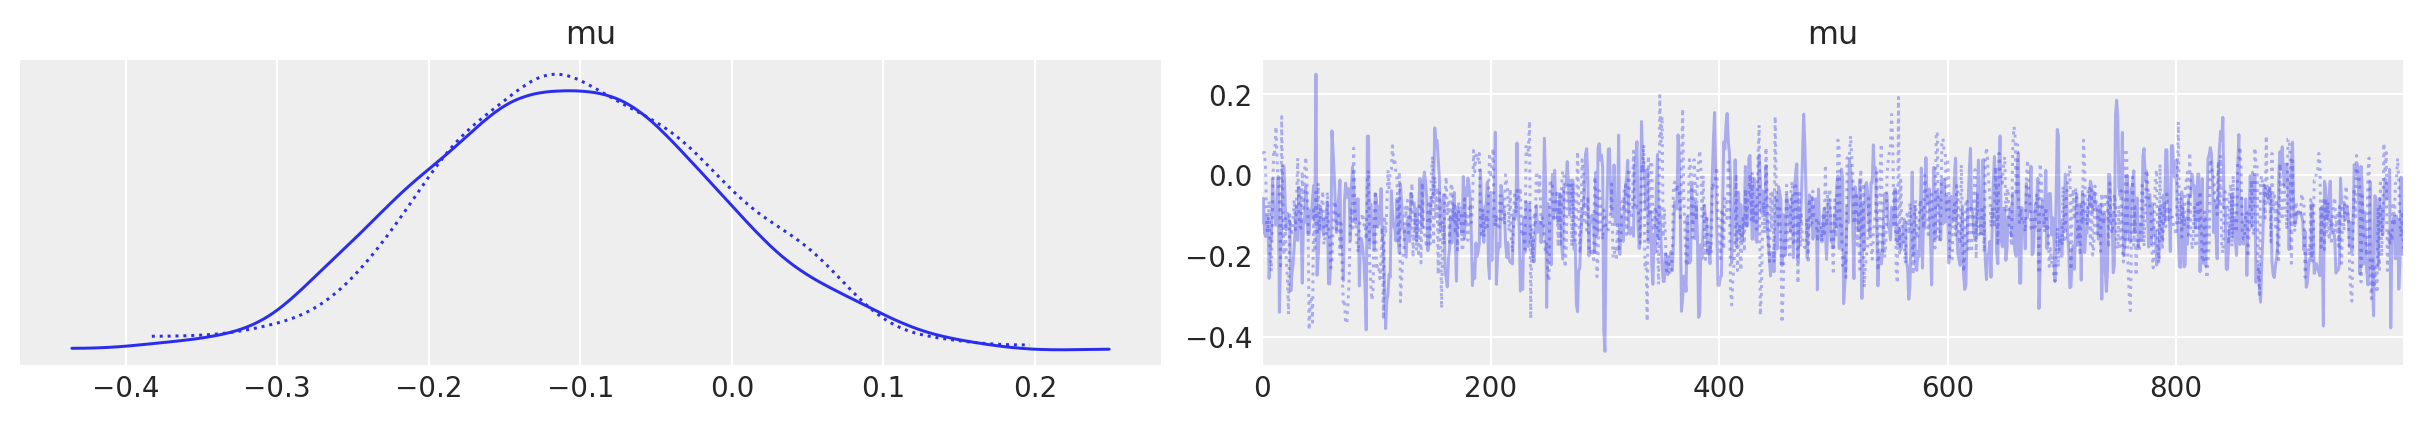

In [47]:
idata = az.from_numpyro(mcmc)
az.plot_trace(idata);

# 手計算

共役事前分布としての正規分布
$$ p(\mu|D;\sigma, \mu_0, \sigma_0) \propto exp[- \frac{N\sigma_0^2 + \sigma^2}{2\sigma^2\sigma_0^2} (\mu - \frac{N\sigma_0^2 \bar x + \sigma^2\mu_0}{N\sigma_0^2 + \sigma^2})^2] $$

平均値：
$$ \frac{N\sigma_0^2 \bar x + \sigma^2\mu_0}{N\sigma_0^2 + \sigma^2}$$

分散：
$$ \frac{\sigma^2\sigma_0^2}{N\sigma_0^2 + \sigma^2} $$ 


In [69]:
x_mean = observed.mean()
x_num = observed.size
sigma_0, sigma = 1, 1
mu_0 = 0

# 平均の分子
molecular_ave = x_num * (np.square(sigma_0)) * x_mean + (np.square(sigma)) * mu_0
# 平均の分母
denominator_ave = x_num * (np.square(sigma_0)) + (np.square(sigma))

# 平均
mu_ave = molecular_ave / denominator_ave

print("平均:{:.3f}".format(mu_ave))

平均:-0.106


In [70]:
# 分散の分子
molecular_var = np.square(sigma) * np.square(sigma_0)
# 分散の分母
denominator_var = x_num * (np.square(sigma_0)) + (np.square(sigma))

# 分散
mu_var = molecular_var / denominator_var
print("分散:{:.3f}".format(mu_var))

分散:0.010


# 比較
手計算した平均値=”-0.106”、可視化した平均値大体は”-0.1”、合っています。